In [2]:
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.autograd as autograd
import EMNIST_dataset_2v as dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from zipfile import ZipFile
from pathlib import Path

In [3]:
!pip install wandb

In [4]:
import wandb

wandb.login()
os.environ["WANDB_API_KEY"] = "x"*40
gpu_id = 0

config = dict(
    n_epochs        = 200,
    batch_size      = 64,
    lr              = 0.0002,
    b1              = 0.5,
    b2              = 0.999,
    n_cpu           = 4,
    latent_dim      = 100,
    img_size        = 32,
    channels        = 1,
    dataset         = "EMNIST",
    model           = "DCGAN",
    optimizer       = "Adam",
    scheduler       = "None",
    sample_interval = 200000
)

wandb_init = dict(
#     job_type: Optional[str] = None,
#     dir = None,
    config = config,
    project = "GAN with EMNIST dataset",
#     entity = None,
#     reinit = None,
    # tags = None,
#     group = None,
    name = None,
    notes = None,
#     magic = None,
#     config_exclude_keys = None,
#     config_include_keys = None,
#     anonymous = None,
    mode = "disabled",  # "online","offline","disabled"
#     allow_val_change = None,
#     resume = None,
#     force = None,
#     tensorboard = None,
#     sync_tensorboard = None,
#     monitor_gym = None,
    save_code = True,
#     settings=None
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ohmygoose0410. Use `wandb login --relogin` to force relogin


In [5]:
if not os.path.exists('./dataset/gzip'):
    with ZipFile("./dataset/gzip.zip", 'r') as zObject:
        zObject.extractall(path="./dataset")

os.makedirs("images_dcgan", exist_ok=True)

torch.manual_seed(42)
torch.backends.cudnn.deterministic=True

torch.cuda.set_device(gpu_id)
device = torch.device("cuda:{}".format(str(gpu_id)) if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

gzip_dir = './dataset/gzip'
save_dataset_dir = './dataset/emnist-byclass_dataset'
model_dir = './model_dcgan'

os.makedirs(model_dir, exist_ok=True)

if not os.path.exists(save_dataset_dir):
    data = dataset.gz2jpg(gz_dataset_dir=gzip_dir, mode='byclass', save_imagelabel_dir=save_dataset_dir)
mytransform=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
train_dataset = dataset.MyDataset(os.path.join(*[save_dataset_dir,'new_train_set.json']), mytransform)
test_dataset = dataset.MyDataset(os.path.join(*[save_dataset_dir,'new_test_set.json']), mytransform)
train_loader = torch.utils.data.DataLoader( train_dataset,
                                        batch_size=config['batch_size'],
                                        shuffle=True,
                                        num_workers=config['n_cpu'],
                                        pin_memory=True)
print("the length of train dataset: ", train_dataset.__len__())

device 0 NVIDIA GeForce RTX 3060 Laptop GPU
the length of train dataset:  60367


In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = config['img_size'] // 4
        self.l1 = nn.Sequential(nn.Linear(config['latent_dim'], 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, config['channels'], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(config['channels'], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        ds_size = config['img_size'] // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

adversarial_loss = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config['lr'], betas=(config['b1'], config['b2']))

Tensor = torch.cuda.FloatTensor if device == torch.device('cuda:{}'.format(str(gpu_id))) else torch.FloatTensor

In [10]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(Tensor(np.random.normal(0, 1, (n_row ** 2, config['latent_dim']))))
    gen_imgs = generator(z)
    save_image(gen_imgs.data, "images_dcgan/%d.png" % batches_done, nrow=n_row, normalize=True)


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss, n=1):
        self.loss = loss
        self.sum += loss * n
        self.count += n
        self.avg = self.sum / self.count
        
def find_latest_model_path(dir):
    model_paths = []
    epochs = []
    for path in Path(dir).glob('*.pt'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

g_loss_list = []
d_loss_list = []

latest_model_path = find_latest_model_path(model_dir)

if latest_model_path is not None:
    state = torch.load(latest_model_path, map_location='cuda:0')
    epoch = state['epoch']
    generator.load_state_dict(state['gen_model'])
    discriminator.load_state_dict(state['dis_model'])
    optimizer_G.load_state_dict(state['optimizer_G'])
    optimizer_D.load_state_dict(state['optimizer_D'])
    epoch = epoch

    # torch.save(generator.state_dict(),os.path.join(*[model_dir,'Generator weights.pth']))
    # torch.save(discriminator.state_dict(),os.path.join(*[model_dir,'Discriminator weights.pth']))

    best_state = torch.load(latest_model_path, map_location='cuda:0')
    curr_g_loss = best_state['g_loss']
    curr_d_loss = best_state['d_loss']

    print(f'Restored model at epoch {epoch}.')
    print(f'Min generator loss so far is : {curr_g_loss}.')
    print(f'Min discriminator loss so far is : {curr_d_loss}.')
    epoch += 1
    print(f'Started training model from epoch {epoch}')
else:
    print('Started training model from epoch 0')
    epoch = 0

run = wandb.init(**wandb_init)

wandb.watch(generator, criterion=None, log="all", log_freq=10)
wandb.watch(discriminator, criterion=None, log="all", log_freq=10)
start_time = time.time()

for epoch in range(epoch, config['n_epochs']):

    tq = tqdm(total=(train_dataset.__len__()))
    tq.set_description(f'Epoch {epoch}')
    
    g_loss_avg = AverageMeter()
    d_loss_avg = AverageMeter()

    for i, (imgs, _) in enumerate(train_loader):

        batch_size = imgs.shape[0]

        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], config['latent_dim']))))

        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss_avg.update(g_loss.cpu().item())

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss_avg.update(d_loss.cpu().item())

        d_loss.backward()
        optimizer_D.step()      

        tq.set_postfix({ 'd_loss':'{:.5f}'.format(d_loss_avg.avg),
                         'g_loss':'{:.5f}'.format(g_loss_avg.avg)})
        tq.update(batch_size)
    tq.close()
    
    g_loss_list.append(g_loss_avg.avg)
    d_loss_list.append(d_loss_avg.avg)
    wandb.log({"generator_training_loss": g_loss_avg.avg})
    wandb.log({"discriminator_training_loss": d_loss_avg.avg})

    epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pt'])
    torch.save({
        'gen_model': generator.state_dict(),
        'dis_model': discriminator.state_dict(),
        'epoch': epoch,
        'g_loss': g_loss_avg.avg,
        'd_loss': d_loss_avg.avg,
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_D': optimizer_D.state_dict()
    }, epoch_model_path)

    sample_image(n_row=10, batches_done=epoch)

finished_training_time = (time.time()-start_time)
print(f"training_time(s): ", finished_training_time)
wandb.log({"training_time(s)": finished_training_time})

run.finish()

Restored model at epoch 199.
Min generator loss so far is : 11.47869143150663.
Min discriminator loss so far is : 0.015556125240829125.
Started training model from epoch 200


training_time(s):  0.0


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


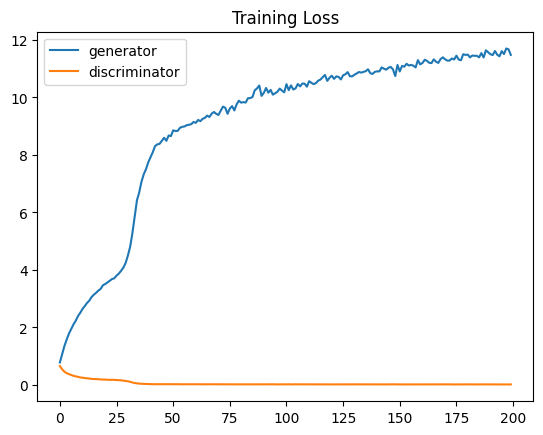

In [9]:
def plot_training_graph(model_dir: str, plot_title: str='', save_plot_path: str=None):  
    paths = [path for path in Path(model_dir).glob('*.pt')]
    paths = sorted(paths)
    epochs = []
    g_losses = []
    d_losses = []
    for path in tqdm(paths):
        if 'epoch' not in path.stem:
            continue
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)
        state = torch.load(path, map_location='cuda:0')
        g_los = state['g_loss']
        d_los = state['d_loss']

        g_losses.append(g_los)
        d_losses.append(d_los)

    sorted_idxs = np.argsort(epochs)
    g_losses = [g_losses[idx] for idx in sorted_idxs]
    d_losses = [d_losses[idx] for idx in sorted_idxs]

    plt.plot(g_losses, label='generator')
    plt.plot(d_losses, label='discriminator')
    plt.title(plot_title)
    plt.legend()
    
    if save_plot_path is not None:
        plt.savefig(save_plot_path, dpi=256)
        
    plt.show()
    
plot_training_graph(model_dir=model_dir, plot_title='Training Loss', save_plot_path='./dcgan_training_loss.jpg')